<a href="https://colab.research.google.com/github/aishwarya-agrawal/twitter-analysis/blob/master/ULMFitontweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files 
uploaded = files.upload()


Saving Tweets.csv to Tweets.csv


In [0]:
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [0]:
df = pd.read_csv(io.StringIO(uploaded['Tweets.csv'].decode('utf-8')))

In [28]:
df['airline'].unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways', 'American'], dtype=object)

In [29]:
df.shape

(14640, 15)

In [30]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
train,test = train_test_split(df, test_size=0.33, random_state=42)

In [0]:
def clean_ascii(text):
    # function to remove non-ASCII chars from data
    return ''.join(i for i in text if ord(i) < 128)



In [34]:
import torch
print("Cuda available" if torch.cuda.is_available() is True else "CPU")
print("PyTorch version: ", torch.__version__)

Cuda available
PyTorch version:  1.0.1.post2


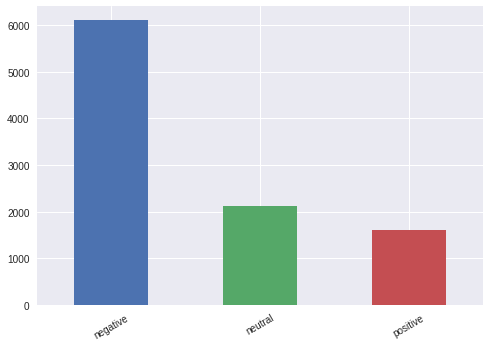

In [35]:
train['airline_sentiment'].value_counts().plot.bar(rot=30);

In [36]:
train['text'] = train['text'].apply(clean_ascii)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
train.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
7475,569577005278064640,neutral,0.6529,NaN,NaN,Delta,NaN,PumaSF,NaN,0,@JetBlue of course I am!!,NaN,2015-02-22 11:18:34 -0800,San Francisco,Pacific Time (US & Canada)
14324,569633482915209216,negative,1.0000,Late Flight,0.6668,American,NaN,MarciNeedham,NaN,0,@AmericanAir complt incompetence on flt 295.La...,NaN,2015-02-22 15:03:00 -0800,NaN,NaN
6472,567829997668470785,negative,0.6566,Late Flight,0.3385,Southwest,NaN,DontenPhoto,NaN,0,@SouthwestAir Flight 4968 (N8325D) departs @MC...,NaN,2015-02-17 15:36:35 -0800,"Englewood, Florida",Eastern Time (US & Canada)
9675,569725021951791104,negative,1.0000,Can't Tell,0.6917,US Airways,NaN,ThomasBowser19,NaN,0,@USAirways does anyone from your airline know ...,NaN,2015-02-22 21:06:44 -0800,NaN,NaN
4047,567852278893416448,neutral,0.6837,NaN,NaN,United,NaN,DanielBmxUs,NaN,0,@united I Want a Plane dad,NaN,2015-02-17 17:05:08 -0800,└A,Eastern Time (US & Canada)


In [38]:
train1 = pd.concat([train['airline_sentiment'], train['text']], axis=1)
train1.tail()

,airline_sentiment,text
5191,positive,@SouthwestAir replacing @vitaminwater with bee...
13418,negative,@AmericanAir at LAX and your service reps just...
5390,negative,@SouthwestAir Been on hold for over an hour - ...
860,negative,@united we would...how do I contact you to dis...
7270,neutral,@JetBlue that's ok! It just sure seemed like i...


In [40]:
!mkdir train

mkdir: cannot create directory ‘train’: File exists


In [0]:
train1.to_csv('train/train.csv', index=False, header=False)

In [0]:
data_lm = TextLMDataBunch.from_csv('train/', 'train.csv', min_freq=1)

In [0]:
# Save the language and classifier model data for re-use
data_lm.save()

In [44]:
data_lm.show_batch()

idx,text
0,"@usairways xxmaj secondary screenings , a piece of the plane missing ... xxmaj anything you want to tell us ? xxbos @usairways please have your people hold flight 599 from xxmaj phoenix to xxmaj san xxmaj jose . xxmaj we pulling up to the gate ! xxmaj scheduled to depart at 5:40 xxbos @southwestair your wifi is shit . fix that up before i jump out of the closest bloody"
1,"else 's complaints but not mine . xxmaj you just lost a customer xxbos @virginamerica i am all about the in flight artisanal cheese and wine pairing . xxbos @southwestair oh my gosh ! xxmaj going to dm you now ! xxmaj thank you ! xxbos @americanair 953 our fligth xxmaj somthing to talk about this ? xxbos @united the ones who suffer . i understand delays , i do"
2,"or at least you did n't care about my sister xxbos @usairways i understand that but i should still be able to view my reservation online xxrep 4 . xxbos @usairways is there an additional charge for a golf bag with clubs , shoes , and golf balls , if that 's the only piece of luggage you check ? xxbos @southwestair any delays today @cakairport to xxmaj orlando ?"
3,condom - xxmaj rito xxmaj family . xxmaj we r 501(c)(3)thanks xxbos @southwestair flight to xxmaj san xxmaj diego is delayed per usual .. take me home ! xxbos @southwestair xxmaj awesome - thanks ! xxbos @americanair xxmaj was not on board you today just watched report unfold on xxmaj twitter but still am very proud ! xxbos @southwestair xxup thank xxup you xxup so xxup much ! ! http
4,"@usairways what is going on with the computers ? xxmaj why is my flight grounded ? xxmaj why does your airline suck so much ? # unansweredquestions xxbos @jetblue @southwestair @virginamerica @americanairbr download jeokoo the xxmaj american app for air travelers xxbos @usairways the gate agent said "" it 's booked in full . xxmaj sorry "" i had a ticket with a 1st class seat . i will call"


In [0]:
learn = language_model_learner(data_lm,arch=AWD_LSTM, pretrained=True, drop_mult=0.1)

In [46]:
list(learn.model.children())

[AWD_LSTM(
   (encoder): Embedding(11097, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(11097, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1150, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1150, 1150, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1150, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=11097, bias=True)
   (output_dp): RNNDropout()
 )]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


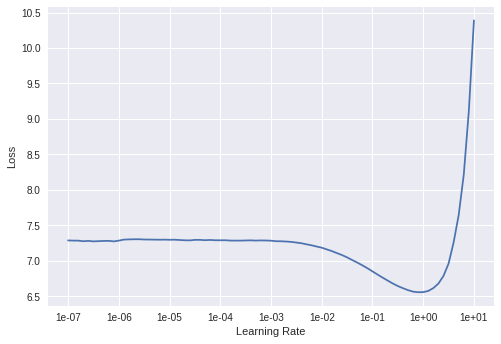

In [47]:


learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()



In [0]:


learn = language_model_learner(data_lm,arch =AWD_LSTM, pretrained=True, 
                               drop_mult=0.5)
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))


In [48]:
learn.unfreeze()
learn.fit_one_cycle(cyc_len=10, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.351861,5.432981,0.195049,00:20
1,5.657447,4.859128,0.220434,00:20
2,4.981504,4.248353,0.250670,00:20
3,4.484475,4.106068,0.259801,00:20
4,4.124218,4.055568,0.264164,00:20
5,3.832788,4.066784,0.263555,00:20
6,3.589617,4.093433,0.260958,00:20
7,3.383710,4.138109,0.258360,00:20
8,3.236591,4.162864,0.257549,00:20
9,3.147480,4.168333,0.258259,00:20


In [0]:
# Save the fine-tuned encoder
learn.save_encoder('ft_enc')

In [50]:
for item in train.airline.unique():
    print(item)

Delta
American
Southwest
US Airways
United
Virgin America


In [0]:
topic = "Delta"

In [0]:
# Get only those tweets that pertain to a single topic in the training data
train_topic = train1.loc[train['airline'] == topic]

In [0]:

train_topic.to_csv('train/train_topic.csv', index=False, header=False)

In [0]:
# Classifier model data
data_clas = TextClasDataBunch.from_csv('train/', 'train_topic.csv', vocab=data_lm.train_ds.vocab,
                                       min_freq=1, bs=32)
data_clas.save()


In [0]:
learn = text_classifier_learner(data_clas, drop_mult=0.5,arch =AWD_LSTM)
learn.load_encoder('ft_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


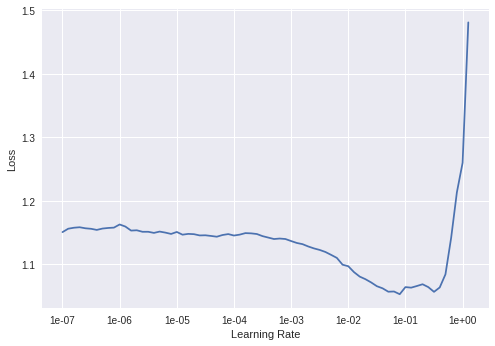

In [57]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [58]:
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.013948,0.899309,0.670068,00:02


In [59]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.920211,0.737668,0.659864,00:03


In [60]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.788872,0.709351,0.710884,00:04


In [61]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.780699,0.701644,0.700680,00:05
1,0.776952,0.683001,0.704082,00:05
2,0.768050,0.682602,0.697279,00:05
3,0.752400,0.683271,0.700680,00:05


In [62]:
# get predictions
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis=1)
pd.crosstab(predictions, targets)

col_0,0,1,2
row_0,,,
0,97,25,16
1,16,57,9
2,7,15,52


In [63]:
test = test.drop(['tweet_id'], axis=1)
# test['Tweet'] = test['Tweet'].apply(clean_ascii)
test.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
4794,positive,1.0000,NaN,NaN,Southwest,NaN,JasmineDT,NaN,1,@SouthwestAir you're my early frontrunner for ...,NaN,2015-02-22 21:30:54 -0800,Washington D.C.,Eastern Time (US & Canada)
10480,negative,1.0000,Cancelled Flight,1.0000,US Airways,NaN,ElizabethFrayer,NaN,0,@USAirways how is it that my flt to EWR was Ca...,NaN,2015-02-21 14:32:19 -0800,NaN,NaN
8067,negative,1.0000,Late Flight,0.6770,Delta,NaN,The_Radifier,NaN,0,@JetBlue what is going on with your BDL to DCA...,NaN,2015-02-20 09:05:13 -0800,"Arlington, VA",Atlantic Time (Canada)
8880,neutral,1.0000,NaN,NaN,Delta,NaN,rnlewisjr,NaN,0,@JetBlue do they have to depart from Washingto...,NaN,2015-02-17 12:01:29 -0800,"iPhone: 60.495510,-151.064590",Alaska
8292,negative,0.6625,Customer Service Issue,0.3394,Delta,NaN,beantoon,NaN,0,@JetBlue I can probably find some of them. Are...,NaN,2015-02-19 13:44:20 -0800,"Plymouth, MA",NaN


In [64]:
test_pred = test[['airline', 'text']]
test_pred = test_pred.loc[test_pred['airline'] == topic]
test_pred.tail()

,airline,text
7573,Delta,@JetBlue Thanks for the personalized customer ...
8159,Delta,@JetBlue probably not anymore.
7456,Delta,@JetBlue wondering if it's possible for my col...
8700,Delta,@JetBlue's CEO Battles to Appease Passengers a...
7831,Delta,@JetBlue Kudos to JetBlue social media team fo...


In [0]:
test_pred['airline_sentiment'] = test_pred['text'].apply(lambda row: str(learn.predict(row)[0]))

In [0]:
!cd train

In [67]:
!ls

adc.json  data	gdrive	models	train  Tweets.csv


In [68]:
% cd ..

/


In [71]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'ulmfitontweet/'


Mounted at /content/gdrive


In [0]:
% mkdir test

In [74]:
% cd test

/test


In [0]:
% mkdir eval

In [78]:
% cd ..

/


In [0]:
test_pred.to_csv('test/eval/predicted.csv', index=True,
                 header=['airline', 'text', 'airline_sentiment'], index_label='ID')

In [80]:
%cd test


/test


In [81]:

%cd eval

/test/eval


In [0]:
file = pd.read_csv('predicted.csv')

In [83]:
!ls

predicted.csv


In [84]:
file.head()

,ID,airline,text,airline_sentiment
0,8067,Delta,@JetBlue what is going on with your BDL to DCA...,negative
1,8880,Delta,@JetBlue do they have to depart from Washingto...,neutral
2,8292,Delta,@JetBlue I can probably find some of them. Are...,neutral
3,7894,Delta,@JetBlue Thank you ! What about Paris ? Could ...,neutral
4,7458,Delta,@JetBlue now we dont have enough money for par...,negative


In [85]:
test['airline_sentiment'][df['airline']=='Delta'].head()

8067    negative
8880     neutral
8292    negative
7894     neutral
7458    negative
Name: airline_sentiment, dtype: object